# Our Implementation

In [1]:
class MetaLogger:
    def __init__(self, filepath="meta.txt"):
        self.filepath = filepath
        self.logs = []

    def log_test(self, x, y, S, p_val, alpha):
        result = "ind" if p_val > alpha else "dep"
        line = f"{x} {result} {y} | {tuple(S)} with p-value {p_val:.6f}"
        self.logs.append(line)

    def log_orientation(self, src, dst, rule_name):
        line = f"Oriented: {src} → {dst} by rule: {rule_name}"
        self.logs.append(line)

    def write(self):
        with open(self.filepath, "w", encoding="utf-8") as f:
            for line in self.logs:
                f.write(line + "\n")

In [2]:
# Importing essential libraries 

import dcor #for permutation test (non linear)

import itertools
import scipy.stats as stats
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from math import log, sqrt
from collections.abc import Iterable
from scipy.stats import chi2, norm
from causallearn.search.ConstraintBased.PC import pc
logger = MetaLogger()

In [3]:
"""
    Find neighbors of node x excluding node y (i.e., Adjacencies(x) \ {y})
    
    param Graph: Adjacency matrix of the graph (2D NumPy array), where Graph[i][j] = 1 indicates an edge from node i to node j
    param x: Index of the node x (integer)
    param y: Index of the node y (integer to exclude from x's neighbors)
    
    return: List of node indices that are direct neighbors of x, excluding y
"""

def neighborsFind(Graph, x, y): 
    neighbors = np.where(Graph[x] == 1)[0]
    neighbors = neighbors[neighbors != y]
    return neighbors.tolist()

In [4]:
"""
    Find all undirected edges in the graph (i.e., bidirectional connections)
    
    param G: Adjacency matrix of the graph (2D NumPy array), 
             where G[i][j] = 1 and G[j][i] = 1 indicates an undirected edge between node i and node j
    
    return: List of tuples (i, j), where each tuple represents an undirected edge (i --- j)
"""

def undirectNodeBrother(G):  
    ind = []
    for i in range(len(G)):
        for j in range(i + 1, len(G)):
            if G[i][j] == 1 and G[j][i] == 1:
                ind.append((i, j))
    return ind

In [5]:
"""
    Perform Fisher's Z Conditional Independence Test between variables Xs and Ys given a condition set

    param df: Input DataFrame containing all relevant variables as columns
    param Xs: Name (string) of the first variable (X)
    param Ys: Name (string) of the second variable (Y)
    param condition_set: List of variable names (strings) to condition on (default is empty list)

    return: p-value from Fisher's Z test for testing conditional independence of Xs and Ys given the condition_set
"""

def calculate_p_val(df, Xs, Ys, condition_set=None):
    if condition_set is None:
        condition_set = []
        
    var = [Xs, Ys] + condition_set
    sub_corr_matrix = np.corrcoef(df[var].T)
    
    try:
        inv = np.linalg.pinv(sub_corr_matrix)
    except np.linalg.LinAlgError:
        raise ValueError('Data correlation matrix is singular. Cannot run fisherz test. Please check your data.')
        
    r = -inv[0, 1] / sqrt(abs(inv[0, 0] * inv[1, 1]))
    if abs(r) >= 1:
        r = (1. - np.finfo(float).eps) * np.sign(r) 
        
    Z = 0.5 * log((1 + r) / (1 - r))
    Z_scaled = sqrt(df.shape[0] - len(condition_set) - 3) * abs(Z) #self.sample_size --> df.shape[0]
    p = 2 * (1 - norm.cdf(abs(Z_scaled)))
    
    return p

In [6]:
"""
    Learn the skeleton (undirected structure) of a causal graph using the PC algorithm's stable skeleton discovery phase

    param df: Input DataFrame where each column is a variable
    param alpha: Significance level for the conditional independence test (Fisher's Z test)
    param labels: List of variable names (column names in the DataFrame)

    return: Dictionary with:
            - 'sk': Final skeleton as an adjacency matrix (0 = no edge, 1 = edge)
            - 'sepset': Separation sets for each variable pair (used in later phases like v-structure orientation)
            - 'ind': List of undirected edges in the form of (i, j) pairs
"""

def skeleton_stable(df, alpha, labels):
    n = len(labels)
    G = np.ones((n, n)) - np.eye(n)  # fully connected undirected graph (no self-loops)
    sepset = [[None for _ in range(n)] for _ in range(n)]

    ord = 0
    done = False

    while not done:
        done = True
        edge_removal = []

        for x in range(n):
            for y in range(n):
                if x == y: #Skip self-loops and already removed edges
                    continue
                if G[x][y] == 0: #Skip self-loops and already removed edges
                    continue

                neighbors_x = [i for i in range(n) if G[x][i] == 1 and i != y] #neighbors of x excluding y 
                if len(neighbors_x) < ord:
                    continue

                found_sep = False
                for S in itertools.combinations(neighbors_x, ord):
                    S_labels = [labels[i] for i in S]
                    p_val = calculate_p_val(df, labels[x], labels[y], S_labels)

                    result = "ind" if p_val > alpha else "dep"
                    logger.log_test(x, y, S, p_val, alpha) #for generating meta file 
                    print(f"{x} {result} {y} | {tuple(S)} with p-value {p_val:.6f}")

                    if p_val > alpha:
                        sepset[x][y] = list(S)
                        sepset[y][x] = list(S)
                        edge_removal.append((x, y))
                        found_sep = True
                        break

                if not found_sep and len(neighbors_x) >= ord:
                    done = False  # More combinations possible at higher order

        for x, y in edge_removal:
            G[x][y] = 0
            G[y][x] = 0

        ord += 1

    ind = [(i, j) for i in range(n) for j in range(i + 1, n) if G[i][j] == 1]
    return {'sk': G, 'sepset': sepset, 'ind': ind}

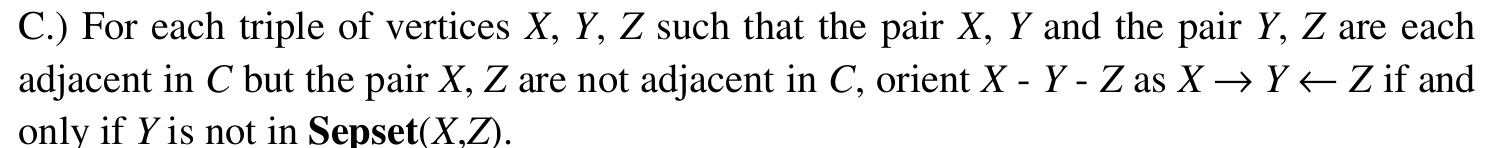

In [7]:
"""
    Identify and orient V-structures in the graph
    
    param Graph: Dictionary output from skeleton_stable() containing:
                 - 'sk': adjacency matrix of the undirected skeleton
                 - 'sepset': separation sets from conditional independence tests
    param labels: List of variable names (used for readable logging and print statements)
    
    return: Updated adjacency matrix with v-structures oriented:
            If x - y - z and x and z are not connected, and y ∉ SepSet(x,z), then orient as x → y ← z
"""

def V_Structure(Graph, labels): #final version with debug print
    G = Graph['sk']
    Sep = Graph['sepset']
    n = len(labels)

    for y in range(n):
        neighbors = [i for i in range(n) if G[y][i] == 1 and G[i][y] == 1]
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                x = neighbors[i]
                z = neighbors[j]

                # Enforce consistent order (x < z) to avoid processing twice
                if x > z:
                    x, z = z, x

                # Check unshielded triple: x - y - z, but x and z not connected
                if G[x][z] == 0 and G[z][x] == 0:
                    sep_xz = Sep[x][z] if Sep[x][z] is not None else []
                    sep_zx = Sep[z][x] if Sep[z][x] is not None else []

                    if y not in sep_xz and y not in sep_zx:
                        # Only orient if still undirected
                        if G[x][y] == 1 and G[y][x] == 1:
                            G[x][y], G[y][x] = 1, 0
                            logger.log_orientation(labels[x], labels[y], "V-Structure")
                        if G[z][y] == 1 and G[y][z] == 1:
                            G[z][y], G[y][z] = 1, 0
                            logger.log_orientation(labels[z], labels[y], "V-Structure")
                        print(f"Orienting v-structure: {labels[x]} → {labels[y]} ← {labels[z]}")

    return G

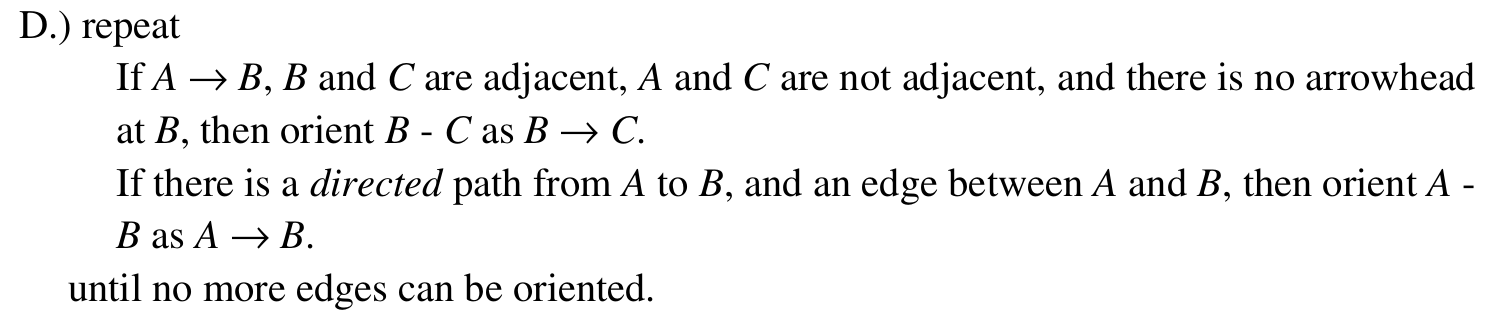

In [8]:
"""
    Check if there is a directed path from 'start' to 'end' in the graph

    param graph: Adjacency matrix representing a partially directed graph
                 - graph[i][j] = 1 and graph[j][i] = 0 ⇒ i → j (directed edge)
    param start: Index of the starting node (integer)
    param end: Index of the ending node (integer)

    return: True if a directed path exists from 'start' to 'end', else False
"""
 
def has_directed_path(graph, start, end): #Depth-First Search (DFS) 
    n = len(graph)
    visited = [False] * n
    stack = [start]

    while stack:
        node = stack.pop()
        if node == end:
            return True
        for neighbor in range(n):
            if graph[node][neighbor] == 1 and graph[neighbor][node] == 0 and not visited[neighbor]:
                visited[neighbor] = True
                stack.append(neighbor)
    return False

In [9]:
"""
    Apply Rule 1: If A → B — C and A is not connected to C, then orient B → C

    param Graph: Adjacency matrix representing a partially directed graph:
                 - Graph[i][j] = 1 and Graph[j][i] = 0 ⇒ i → j (directed edge)
                 - Graph[i][j] = Graph[j][i] = 1 ⇒ i — j (undirected edge)
                 - Graph[i][j] = Graph[j][i] = 0 ⇒ no edge
    param labels: List of variable names (used for logging and readable printout)

    return: 
        - Updated adjacency matrix with new orientations applied
        - Boolean flag 'changed' indicating whether any edge was oriented in this pass
"""

def rule1(Graph, labels):
    changed = False
    n = len(Graph)
    for a in range(n):
        for b in range(n):
            if Graph[a][b] == 1 and Graph[b][a] == 0:  # A → B
                for c in range(n):
                    if (
                        Graph[b][c] == 1 and Graph[c][b] == 1  # B — C
                        and Graph[a][c] == 0 and Graph[c][a] == 0  # A not connected to C
                        and len({a, b, c}) == 3
                    ):
                        Graph[b][c] = 1
                        Graph[c][b] = 0
                        logger.log_orientation(labels[b], labels[c], "Rule 1")
                        changed = True
    return Graph, changed

In [10]:
"""
    Apply Rule 2: If A — B and there exists a directed path A → ... → B, 
    then orient the undirected edge A — B as A → B to maintain acyclicity.

    param Graph: Adjacency matrix of a partially directed graph
                 - Graph[i][j] = 1 and Graph[j][i] = 0 ⇒ i → j (directed)
                 - Graph[i][j] = Graph[j][i] = 1 ⇒ i — j (undirected)
    param labels: List of variable names (for readable logging)

    return:
        - Updated adjacency matrix after applying Rule 2
        - Boolean flag 'changed' indicating whether any orientation was made
"""

def rule2(Graph, labels):
    changed = False
    n = len(Graph)
    for a in range(n):
        for b in range(n):
            if Graph[a][b] == 1 and Graph[b][a] == 1:  # A — B
                if has_directed_path(Graph, a, b) and not has_directed_path(Graph, b, a):
                    Graph[a][b] = 1
                    Graph[b][a] = 0
                    logger.log_orientation(labels[a], labels[b], "Rule 2")
                    changed = True
    return Graph, changed

In [11]:
"""
    Apply Rules 1 and 2 iteratively until no further orientations are possible.
"""

def extend_cpdag(graph, labels):
    changed = True
    pdag = graph.copy()
    while changed:
        changed = False
        pdag, ch1 = rule1(pdag, labels)
        pdag, ch2 = rule2(pdag, labels)
        changed = ch1 or ch2
    return pdag

In [12]:
def pc_scratch(df, alpha, labels):
    skeletonGraph = skeleton_stable(df, alpha, labels)
    Ved_Graph = V_Structure(skeletonGraph, labels)
    CPDAG = extend_cpdag(Ved_Graph, labels)
    logger.write()
    return CPDAG

In [13]:
#this particular dataset is from causal-learns github repo

data = pd.read_csv("data_linear_10.txt", delimiter='\t')
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
0,0.4267,-3.8347,0.8206,2.2105,-0.8013,1.4460,0.8459,1.4308,3.0604,0.8405,0.0702,4.6897,-3.0022,2.8682,1.0541,2.7330,3.0229,0.9423,-0.8682,4.9939
1,-2.4931,-0.2551,-2.6704,2.0178,-0.7049,7.4380,3.9722,-2.8322,-4.0656,1.1816,2.7889,-4.1794,2.1017,-2.2248,7.7386,0.2391,0.4254,0.2544,-12.4602,4.6741
2,-2.3450,-0.7138,-1.5770,2.4113,-1.3931,4.7314,4.2719,0.6038,-0.8459,-1.8778,2.4730,-0.7752,1.6664,2.4615,6.5918,2.5848,1.6579,0.3791,-1.4242,1.7615
3,0.5609,1.6192,0.8243,-2.5997,3.9722,-2.8288,-0.5800,-4.8029,-4.4598,0.3420,2.3298,0.1763,1.6154,-8.7003,0.0595,-0.9549,2.2288,4.4123,-5.3234,-10.3425
4,-1.5008,4.5678,-4.5492,1.9965,-1.1495,3.1489,2.9886,-0.6434,-5.1042,4.9278,2.0321,4.8462,6.5701,1.8526,-1.3688,-4.0556,-1.6571,2.2747,3.9251,1.6304


In [14]:
result = pc_scratch(data, 0.05, data.columns)

0 ind 1 | () with p-value 0.877712
0 dep 2 | () with p-value 0.000000
0 dep 3 | () with p-value 0.000000
0 dep 4 | () with p-value 0.000000
0 dep 5 | () with p-value 0.000000
0 dep 6 | () with p-value 0.000000
0 dep 7 | () with p-value 0.000000
0 dep 8 | () with p-value 0.000000
0 dep 9 | () with p-value 0.000000
0 ind 10 | () with p-value 0.202994
0 dep 11 | () with p-value 0.000000
0 dep 12 | () with p-value 0.000000
0 ind 13 | () with p-value 0.089027
0 dep 14 | () with p-value 0.000000
0 dep 15 | () with p-value 0.000000
0 ind 16 | () with p-value 0.448786
0 dep 17 | () with p-value 0.000000
0 dep 18 | () with p-value 0.000000
0 dep 19 | () with p-value 0.000000
1 ind 0 | () with p-value 0.877712
1 dep 2 | () with p-value 0.000000
1 ind 3 | () with p-value 0.640631
1 ind 4 | () with p-value 0.214563
1 dep 5 | () with p-value 0.000000
1 dep 6 | () with p-value 0.000000
1 ind 7 | () with p-value 0.574652
1 dep 8 | () with p-value 0.000000
1 dep 9 | () with p-value 0.000000
1 ind 10 |

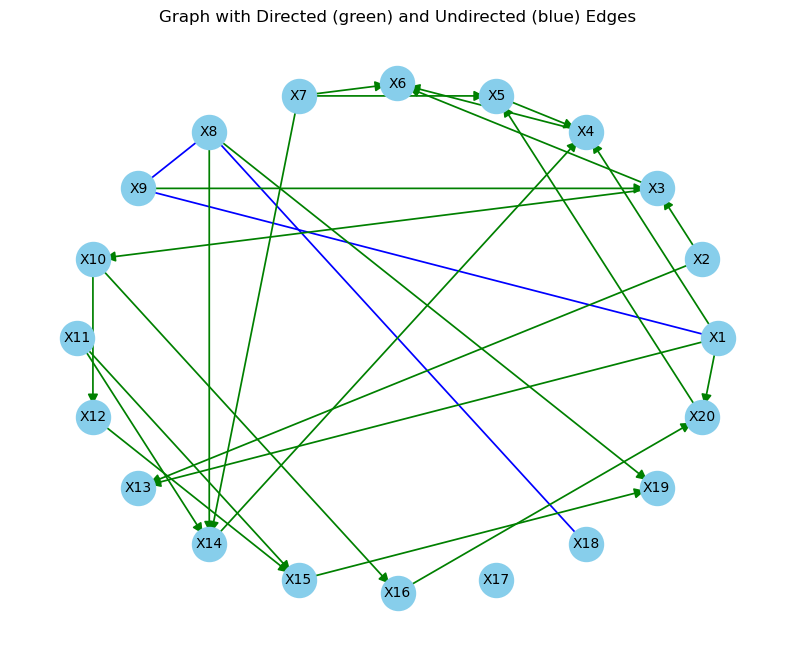

In [15]:
# 1. Create DiGraph from adjacency matrix
G = nx.from_numpy_array(result, create_using=nx.DiGraph)

# 2. Rename node labels to original column names
mapping = {i: name for i, name in enumerate(data.columns)}
G = nx.relabel_nodes(G, mapping)

# 3. Identify directed and undirected edges
directed_edges = []
undirected_edges = []

for u, v in G.edges():
    i, j = list(mapping.keys())[list(mapping.values()).index(u)], list(mapping.keys())[list(mapping.values()).index(v)]
    if result[i, j] == 1 and result[j, i] == 1:
        if (v, u) not in undirected_edges:  # avoid duplicates
            undirected_edges.append((u, v))
    elif result[i, j] == 1 and result[j, i] == 0:
        directed_edges.append((u, v))

# 4. Plot with circular layout
pos = nx.circular_layout(G)
plt.figure(figsize=(10, 8))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color='skyblue')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=undirected_edges, edge_color='blue', arrows=False, style='solid', width=1.25)
nx.draw_networkx_edges(G, pos, edgelist=directed_edges, edge_color='green', arrows=True, arrowsize=15, width=1.25)

plt.title("Graph with Directed (green) and Undirected (blue) Edges")
plt.axis('off')
plt.show()

# Causal-learn 

  0%|          | 0/20 [00:00<?, ?it/s]

Green: undirected; Blue: directed; Red: bi-directed



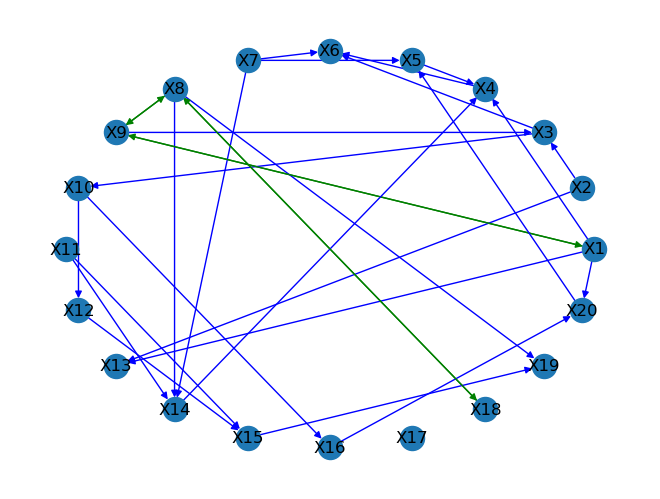

In [16]:
from causallearn.search.ConstraintBased.PC import pc
import networkx as nx

cg = pc(data.values, alpha = 0.05)

# visualization using networkx
cg.to_nx_graph()
cg.draw_nx_graph(skel=False)

In [1]:
"""
    Non-parametric permutation test for conditional independence.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe containing the variables
    X : str
        Name of variable X
    Y : str
        Name of variable Y
    condition_set : list of str, optional
        List of variable names to condition on
    n_permutations : int
        Number of permutations
    random_seed : int
        Random seed for reproducibility
    
    Returns
    -------
    p_value : float
        p-value from the permutation test
    """

def permutation_test(df, X, Y, condition_set=None, n_permutations=500, random_seed=42):
    
    if condition_set is None:
        condition_set = []
    
    rng = np.random.default_rng(random_seed)

    A = df[X].values
    C = df[Y].values
    if len(condition_set) > 0:
        B = df[condition_set].values
    else:
        B = None

    # Observed statistic
    r_observed = dcor.partial_distance_covariance(A, C, B)

    # Permutation statistics
    r_permuted = np.zeros(n_permutations)
    for i in range(n_permutations):
        C_perm = rng.permutation(C)
        r_permuted[i] = dcor.partial_distance_covariance(A, C_perm, B)

    # Compute p-value
    extreme_count = np.sum(np.abs(r_permuted) >= np.abs(r_observed))
    p_value = (1 + extreme_count) / (1 + n_permutations)

    return p_value